In [1]:
from __future__ import print_function

import os
import sys
import time
import argparse
import datetime
import math
import pickle


import torchvision
import torchvision.transforms as transforms
from utils.autoaugment import CIFAR10Policy

import torch
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# from utils.BBBlayers import GaussianVariationalInference
# from utils.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from utils.BayesianModels.BayesianAlexNet import BBBAlexNet
# from utils.BayesianModels.BayesianLeNet import BBBLeNet
# from utils.BayesianModels.BayesianSqueezeNet import BBBSqueezeNet

In [3]:
net_type = 'alexnet'
dataset = 'CIFAR10'
outputs = 10
inputs = 3
resume = False
n_epochs = 150
lr = 0.01
weight_decay = 0.0005
num_samples = 1
beta_type = "Standard"
resize=32

In [4]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 256
# percentage of training set to use as validation
valid_size = 0.2

In [6]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [8]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [10]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    # Uncomment if normalizing the data
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

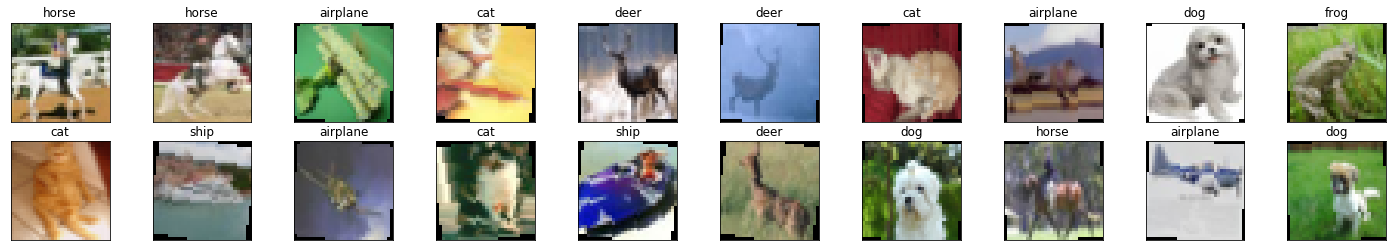

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

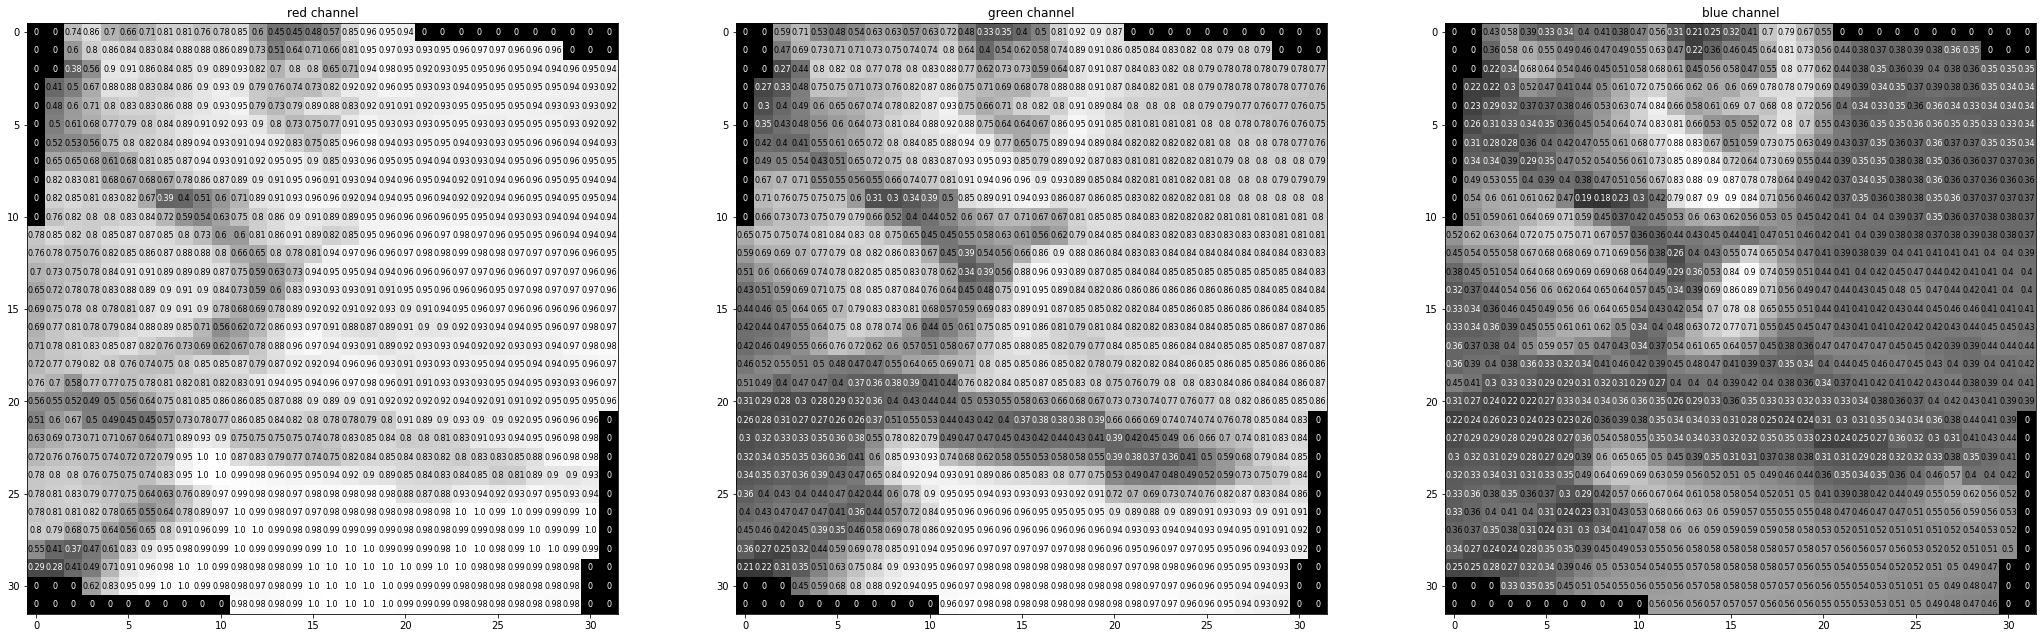

In [13]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [14]:
# Architecture
if (net_type == 'lenet'):
    net = BBBLeNet(outputs,inputs)
elif (net_type == 'alexnet'):
    net = BBBAlexNet( outputs, inputs)
    #net = BBBAlexNet(outputs,inputs)
elif (net_type == '3conv3fc'):
        net = BBB3Conv3FC(outputs,inputs)
else:
    print('Error : Network should be either [LeNet / AlexNet / 3Conv3FC')


In [15]:
if use_cuda:
    net.cuda()

In [16]:
ckpt_name = f'model_{net_type}_{dataset}_bayesian.pt'
ckpt_name

'model_alexnet_CIFAR10_bayesian.pt'

In [17]:

def get_beta(batch_idx, m, beta_type):
    if beta_type == "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1) 
    elif beta_type == "Soenderby":
        beta = min(epoch / (num_epochs // 4), 1)
    elif beta_type == "Standard":
        beta = 1 / m 
    else:
        beta = 0
    return beta



In [18]:
def elbo(out, y, kl, beta):
    loss = F.cross_entropy(out, y)
    return loss + beta * kl

In [19]:
def train(epoch):
    print('Epoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs, kl = net.probforward(inputs)
        loss = elbo(outputs, targets, kl, get_beta(epoch, len(train_data), beta_type))
        loss.backward()
        optimizer.step()
        pred = torch.max(outputs, dim=1)[1]
        correct += torch.sum(pred.eq(targets)).item()
        total += targets.numel()
    print(f'[TRAIN] Acc: {100.*correct/total:.3f}')


In [20]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    accuracy_max = 0    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs, _ = net.probforward(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            accuracy = 100.*correct/total
        print(f'[TEST] Acc: {accuracy:.3f}')
        

    torch.save(net.state_dict(), ckpt_name)
    

In [21]:
epochs = [80, 60, 40, 20]
count = 0

In [22]:
from torch.optim import Adam
for epoch in epochs:
    optimizer = Adam(net.parameters(), lr=lr)
    for _ in range(epoch):
        train(count)
        test(count)
        count += 1
    lr /= 10

Epoch: 0
[TRAIN] Acc: 10.312
[TEST] Acc: 11.650
Epoch: 1
[TRAIN] Acc: 14.680
[TEST] Acc: 17.370
Epoch: 2
[TRAIN] Acc: 18.547
[TEST] Acc: 20.360
Epoch: 3
[TRAIN] Acc: 20.622
[TEST] Acc: 23.000
Epoch: 4
[TRAIN] Acc: 23.003
[TEST] Acc: 26.040
Epoch: 5
[TRAIN] Acc: 25.575
[TEST] Acc: 28.960
Epoch: 6
[TRAIN] Acc: 27.830
[TEST] Acc: 32.320
Epoch: 7
[TRAIN] Acc: 30.573
[TEST] Acc: 31.470
Epoch: 8
[TRAIN] Acc: 32.965
[TEST] Acc: 34.120
Epoch: 9
[TRAIN] Acc: 35.420
[TEST] Acc: 38.260
Epoch: 10
[TRAIN] Acc: 37.240
[TEST] Acc: 37.970
Epoch: 11
[TRAIN] Acc: 39.700
[TEST] Acc: 39.050
Epoch: 12
[TRAIN] Acc: 40.185
[TEST] Acc: 41.280
Epoch: 13
[TRAIN] Acc: 41.895
[TEST] Acc: 41.960
Epoch: 14
[TRAIN] Acc: 43.028
[TEST] Acc: 43.030
Epoch: 15
[TRAIN] Acc: 43.590
[TEST] Acc: 43.950
Epoch: 16
[TRAIN] Acc: 44.822
[TEST] Acc: 45.080
Epoch: 17
[TRAIN] Acc: 44.697
[TEST] Acc: 44.330
Epoch: 18
[TRAIN] Acc: 46.292
[TEST] Acc: 45.620
Epoch: 19
[TRAIN] Acc: 46.215
[TEST] Acc: 44.100
Epoch: 20
[TRAIN] Acc: 46.820


[TRAIN] Acc: 80.272
[TEST] Acc: 59.480
Epoch: 167
[TRAIN] Acc: 80.355
[TEST] Acc: 58.920
Epoch: 168
[TRAIN] Acc: 80.745
[TEST] Acc: 59.580
Epoch: 169
[TRAIN] Acc: 80.767
[TEST] Acc: 58.850
Epoch: 170
[TRAIN] Acc: 80.522
[TEST] Acc: 59.060
Epoch: 171
[TRAIN] Acc: 80.427
[TEST] Acc: 59.100
Epoch: 172
[TRAIN] Acc: 80.300
[TEST] Acc: 59.080
Epoch: 173
[TRAIN] Acc: 80.752
[TEST] Acc: 58.990
Epoch: 174
[TRAIN] Acc: 80.485
[TEST] Acc: 59.010
Epoch: 175
[TRAIN] Acc: 80.725
[TEST] Acc: 58.820
Epoch: 176
[TRAIN] Acc: 80.733
[TEST] Acc: 59.100
Epoch: 177
[TRAIN] Acc: 80.672
[TEST] Acc: 58.580
Epoch: 178
[TRAIN] Acc: 80.515
[TEST] Acc: 59.290
Epoch: 179
[TRAIN] Acc: 80.855
[TEST] Acc: 58.600
Epoch: 180
[TRAIN] Acc: 80.555
[TEST] Acc: 59.050
Epoch: 181
[TRAIN] Acc: 80.927
[TEST] Acc: 59.370
Epoch: 182
[TRAIN] Acc: 81.055
[TEST] Acc: 58.790
Epoch: 183
[TRAIN] Acc: 80.345
[TEST] Acc: 59.360
Epoch: 184
[TRAIN] Acc: 81.028
[TEST] Acc: 59.630
Epoch: 185
[TRAIN] Acc: 80.820
[TEST] Acc: 58.820
Epoch: 186


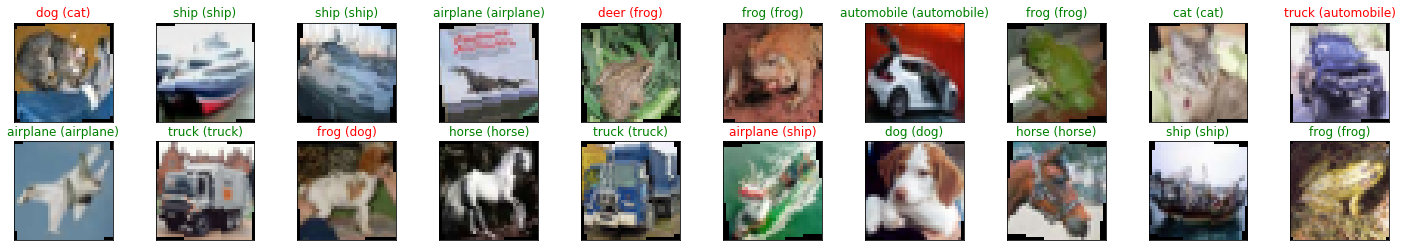

In [23]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output, kl = net.probforward(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))